## Installations

In [1]:
!python --version

Python 3.10.13


In [3]:
# !pip install torch==2.5.1 transformers==4.46.2 datasets wandb huggingface_hub python-dotenv --no-cache-dir | tail -n 1 
# !pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# !pip install --no-deps trl peft accelerate bitsandbytes xformers==0.0.28.post3 --no-cache | tail -n 1 

In [8]:
import torch

# Print Torch version 
print(torch.__version__)

# Check if CUDA (GPU) is available
print("CUDA available:", torch.cuda.is_available())

# Print the number of GPUs
print("Number of GPUs:", torch.cuda.device_count())

# Print the name of the current GPU device
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# Print the current GPU device index
print("Current GPU Device:", torch.cuda.current_device())

2.5.1+cu124
CUDA available: True
Number of GPUs: 1
GPU Name: NVIDIA L40S
Current GPU Device: 0


## Setting Up Weights & Biases

In [ ]:
import os
import wandb
from dotenv import load_dotenv
load_dotenv()

def setup_wandb(project_name: str, run_name: str):
    # Set up your API KEY
    try:
        api_key = os.getenv("WANDB_API_KEY")
        wandb.login(key=api_key)
        print("Successfully logged into WandB.")
    except KeyError:
        raise EnvironmentError("WANDB_API_KEY is not set in the environment variables.")
    except Exception as e:
        print(f"Error logging into WandB: {e}")
    
    # Optional: Log models
    os.environ["WANDB_LOG_MODEL"] = "checkpoint"
    os.environ["WANDB_WATCH"] = "all"
    os.environ["WANDB_SILENT"] = "true"
    
    # Initialize the WandB run
    try:
        wandb.init(project=project_name, name=run_name)
        print(f"WandB run initialized: Project - {project_name}, Run - {run_name}")
    except Exception as e:
        print(f"Error initializing WandB run: {e}")

# Setup WandB
setup_wandb(project_name="llama-3.2-vlm-ft-lora", run_name="run-v1")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gautamgc75 (gautamgc75-org). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/wsuser/.netrc


Successfully logged into WandB.


WandB run initialized: Project - llama-3.2-vlm-ft-lora, Run - run-v1


## HuggingFace Authentication

In [ ]:
from huggingface_hub import login

hf_token = os.getenv("HUGGINGFACE_TOKEN")
if hf_token is None:
    raise EnvironmentError("HUGGINGFACE_TOKEN is not set in the environment variables.")
login(hf_token)

## Loading and Processing the Dataset

In [11]:
from datasets import load_dataset
from PIL import Image

# Loading the dataset
dataset_id = "HuggingFaceM4/the_cauldron"
subset = "geomverse"
dataset = load_dataset(dataset_id, subset, split="train")

# Selecting a subset of 3K samples for fine-tuning
dataset = dataset.select(range(3000))
print(f"Using a sample size of {len(dataset)} for fine-tuning.")
print(dataset)

Using a sample size of 3000 for fine-tuning.
Dataset({
    features: ['images', 'texts'],
    num_rows: 3000
})


In [12]:
dataset[5]

{'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1936x1699>],
 'texts': [{'user': 'If the brown shape is a square where a circle has been removed from it and the perimeter of the purple triangle is 49, compute the area of the brown shape. Assume $\\pi=3.14$. Round computations to 2 decimal places.',
   'assistant': 'The lengths of two sides of the purple triangle are 23 and 10 and the perimeter is 49, so the lengths of the side marked with "$a$" equals $49 - 23 - 10 = 16$. The length of the side of the brown shape is 16, so its area is $16^2 - \\frac{\\pi}{4} * (16^2) = 256 - 0.79 * 256 = 256 - 202.24 = 53.76$. Therefore the final answer is 53.76.',
   'source': 'GeomVerse'}]}

Image Mode: RGB
Image Size: (1936, 1699)
Image Type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Displaying the Image:


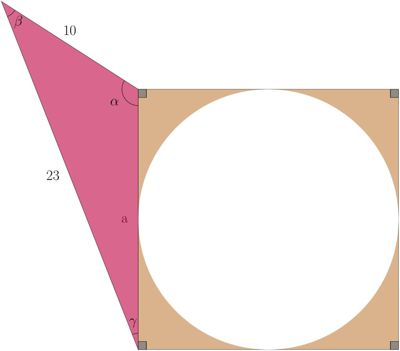

In [13]:
# Print the mode of the image in dataset[5]
print(f"Image Mode: {dataset[5]['images'][0].mode}")

# Print the size of the image in dataset[5]
print(f"Image Size: {dataset[5]['images'][0].size}")

# Print the type of the image in dataset[5]
print(f"Image Type: {type(dataset[5]['images'][0])}")

# Display the image - dataset[5]["images"][0].show()
print("Displaying the Image:")
small_image = dataset[5]["images"][0].copy()  # Create a copy to avoid modifying the original
small_image.thumbnail((400, 400))             # Resize to fit within 400x400 pixels
small_image.show()

In [14]:
def convert_to_rgb(image):
    """Convert image to RGB format if not already in RGB."""
    if image.mode == "RGB":
        return image

    # Convert to RGBA, composite over a white background, and finally to RGB
    image_rgba = image.convert("RGBA")
    background = Image.new("RGBA", image_rgba.size, (255, 255, 255))
    alpha_composite = Image.alpha_composite(background, image_rgba)
    return alpha_composite.convert("RGB")


def reduce_image_size(image, scale=0.5):
    """Reduce image size by a given scale."""
    original_width, original_height = image.size
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)
    return image.resize((new_width, new_height))


def format_data(sample):
    """Format the dataset sample into structured messages."""
    image = sample["images"][0]
    image = convert_to_rgb(image)  
    image = reduce_image_size(image)

    return {
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": sample["texts"][0]["user"],
                    },
                    {
                        "type": "image",
                        "image": image,  
                    }
                ],
            },
            {
                "role": "assistant",
                "content": [
                    {
                        "type": "text",
                        "text": sample["texts"][0]["assistant"],
                    }
                ],
            },
        ],
    }


# Transform the dataset
converted_dataset = [format_data(sample) for sample in dataset]

In [15]:
converted_dataset[5]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'If the brown shape is a square where a circle has been removed from it and the perimeter of the purple triangle is 49, compute the area of the brown shape. Assume $\\pi=3.14$. Round computations to 2 decimal places.'},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=968x849>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'The lengths of two sides of the purple triangle are 23 and 10 and the perimeter is 49, so the lengths of the side marked with "$a$" equals $49 - 23 - 10 = 16$. The length of the side of the brown shape is 16, so its area is $16^2 - \\frac{\\pi}{4} * (16^2) = 256 - 0.79 * 256 = 256 - 202.24 = 53.76$. Therefore the final answer is 53.76.'}]}]}

## Loading the Base Model

In [ ]:
import torch
from unsloth import FastVisionModel 

model_name = "unsloth/Llama-3.2-11B-Vision-Instruct"

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = model_name,
    load_in_4bit = False,                     # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth",   # True or "unsloth" for long context
)

## Configuring LoRA for Fine-Tuning

In [17]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 8,             # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,   # Recommended alpha == r atleast or alpha == 2*r (recommended)
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

## Evaluate the Base Vision Model

In [18]:
FastVisionModel.for_inference(model)         # Enable for inference!

image = dataset[5]["images"][0]
instruction = dataset[5]["texts"][0]["user"]

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": instruction
            },
        ]
    }
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

In [19]:
from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1024,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The information in the image is:

* A brown shape consisting of a square with a circle removed from it.
* The square has a side length of 10 units (as labeled).
* The circle has a radius of 7 units (as labeled).
* The purple triangle has a perimeter of 49 units (as labeled).
* The Greek letters alpha, beta, and gamma are labeled on the purple triangle.
* The Greek letter alpha is also labeled on the circle.
* The variable a is labeled on the side of the square and is the height of the purple triangle.
* The value of pi (π) is given as 3.14.
* Computation of answers should be rounded to 2 decimal places. 
## Step 1
The perimeter of the purple triangle is 49 units.

## Step 2
This means each side of the triangle is $\frac{49}{3}$ units.

## Step 3
Each angle in the triangle is 60 degrees since it is equilateral.

## Step 4
The area of the purple triangle is thus $\frac{\sqrt{3}}{4}\left(\frac{49}{3}\right)^2=49.5\text{ sq. units}.$

## Step 5
The side length of the brown shape is the sam

## Training with SFTTrainer and Unsloth

In [20]:
from trl import SFTTrainer, SFTConfig
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator


args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 3, 
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),

        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "wandb",  
        logging_steps = 1,  
        logging_strategy = "steps",
        save_strategy = "no",
        load_best_model_at_end = True,
        save_only_model = False,
        
        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    )

In [21]:
FastVisionModel.for_training(model)    # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = args,
)

In [22]:
# Show current memory stats

gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L40S. Max memory = 44.521 GB.
22.111 GB of memory reserved.


In [23]:
import torch
import gc

# Clear PyTorch's cache
torch.cuda.empty_cache()

# Run Python's garbage collector
gc.collect()

53377

In [24]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 1,125
 "-____-"     Number of trainable parameters = 33,587,200
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss


In [ ]:
print(trainer_stats)
wandb.finish()

In [ ]:
# Show final memory and time stats

used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

## Saving the Model

After training, the fine-tuned model is saved locally and pushed to Hugging Face's hub for further access and deployment. However, this only saves the LoRA adapters.

In [ ]:
# Local saving
model.save_pretrained("Llama3.2-VLM-FineTune-LoRA-Model") 
tokenizer.save_pretrained("Llama3.2-VLM-FineTune-LoRA-Model")

# Online saving
model.push_to_hub("gautamgc17/Llama3.2-VLM-FineTune-LoRA-Model", token = hf_token)
tokenizer.push_to_hub("gautamgc17/Llama3.2-VLM-FineTune-LoRA-Model", token = hf_token) 

## Saving to float16 for VLLM

For merging the LoRA adapters with the base model and save the model to 16-bit precision for optimized performance with vLLM, use:



In [ ]:
# Merge to 16bit
model.save_pretrained_merged("Llama3.2-VLM-FineTune-Model", tokenizer, save_method = "merged_16bit")
model.push_to_hub_merged("gautamgc17/Llama3.2-VLM-FineTune-Model", tokenizer, save_method = "merged_16bit", token = hf_token)

## Model Evaluation

In [ ]:
from unsloth import FastVisionModel

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "Llama3.2-VLM-FineTune-LoRA-Model", 
    load_in_4bit = False,
)
FastVisionModel.for_inference(model)         # Enable for inference!

In [14]:
from datasets import load_dataset
from PIL import Image

# Loading the dataset
dataset_id = "HuggingFaceM4/the_cauldron"
subset = "geomverse"
dataset = load_dataset(dataset_id, subset, split="train")

In [8]:
image = dataset[-1]["images"][0]
instruction = dataset[-1]["texts"][0]["user"]

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": instruction
            },
        ]
    }
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

In [9]:
messages

[{'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text',
    'text': 'If the area of the ABCD parallelogram is 66, the area of the AEFB rectangle is 114, the AEGH shape is a combination of a rectangle and a semi-circle and the perimeter of the AEGH shape is 62, compute the degree of the DAB angle. Assume $\\pi=3.14$. Round computations to 2 decimal places.'}]}]

In [15]:
print("Ground Truth Answer:", dataset[-1]["texts"][0]["assistant"])

Ground Truth Answer: The perimeter of the AEGH shape is 62 and the length of the EG side is 13, so $2 * OtherSide + 13 + \frac{13 * 3.14}{2} = 62$. So $2 * OtherSide = 62 - 13 - \frac{13 * 3.14}{2} = 62 - 13 - \frac{40.82}{2} = 62 - 13 - 20.41 = 28.59$. Therefore, the length of the AE side is $\frac{28.59}{2} = 14.29$. The area of the AEFB rectangle is 114 and the length of its AE side is 14.29, so the length of the AB side is $\frac{114}{14.29} = 7.98$. The lengths of the AD and the AB sides of the ABCD parallelogram are 22 and 7.98 and the area is 66 so the sine of the DAB angle is $\frac{66}{22 * 7.98} = 0.38$ and so the angle in degrees is $\arcsin(0.38) = 22.33$. Therefore the final answer is 22.33.


In [22]:
from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1024,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The perimeter of the AEGH shape is 62 and the length of the EG side is 13, so $2 * OtherSide + 13 + \frac{13 * 3.14}{2} = 62$. So $2 * OtherSide = 62 - 13 - \frac{13 * 3.14}{2} = 62 - 13 - \frac{40.82}{2} = 62 - 13 - 20.41 = 28.59$. Therefore, the length of the AE side is $\frac{28.59}{2} = 14.29$. The area of the AEFB rectangle is 114 and the length of its AE side is 14.29, so the length of the AB side is $\frac{114}{14.29} = 7.99$. The lengths of the AD and the AB sides of the ABCD parallelogram are 22 and 7.99 and the area is 66 so the sine of the DAB angle is $\frac{66}{22 * 7.99} = 0.36$ and so the angle in degrees is $\arcsin(0.36) = 21.1$. Therefore the final answer is 21.1.<|eot_id|>
